In [1]:
import math
import torch
import gpytorch
from gpytorch.kernels import RBFKernel
from matplotlib import pyplot as plt
import numpy as np
import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = np.genfromtxt("../../heron/models/data/gt-M60-F1024.dat")

In [3]:
training_x = torch.tensor(data[:,[0,1]]*100).float().cuda()
training_y = torch.tensor(data[:,-2]*1e21).float().cuda()

In [4]:
from functools import reduce
import operator
def prod(iterable):
    return reduce(operator.mul, iterable)

In [469]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = (gpytorch.kernels.RBFKernel(active_dims=0,
                                                                                    lengthscale_constraint=gpytorch.constraints.GreaterThan(0.1)
                                                                                   )*gpytorch.kernels.RBFKernel(active_dims=1, 
                                                                                                                #lengthscale_prior=gpytorch.priors.UniformPrior(0.5,1.5).cuda(),
                                                                                                                lengthscale_constraint=gpytorch.constraints.GreaterThan(0.9)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [470]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.LessThan(0.8))
model = ExactGPModel(training_x, training_y, likelihood)

In [471]:
model = model.cuda()
likelihood = likelihood.cuda()

In [472]:
preconditioner_size = 100
n_devices = 1
output_device = torch.device('cuda:0')

In [509]:
training_iterations = 50000
model.train()
likelihood.train()

# We use SGD here, rather than Adam. Emperically, we find that SGD is better for variational regression
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


epochs_iter = tqdm.tqdm_notebook(range(training_iterations), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    # Output from model
    output = model(training_x)
    # Calc loss and backprop gradients
    loss = -mll(output, training_y).cuda()
    loss.backward()
    optimizer.step()

/home/daniel/.virtualenvs/gaston/sandbox/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [510]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): LessThan(8.000E-01)
  )
)

In [511]:
import heron.models

In [512]:
import heron.models.gw

In [513]:
from elk.waveform import Timeseries

In [514]:
class CudaWaveform(heron.models.Model, heron.models.gw.BBHNonSpinSurrogate, heron.models.gw.HofTSurrogate):
    
    time_factor = 1
    x_dimensions = 2
    strain_input_factor = 1e21
    
    def __init__(self, model, likelihood):
        """
        Construct a CUDA-based waveform model with pyTorch
        """
        self.model = model
        #
        self.likelihood = likelihood
        self.eval()
        
    def eval(self):
        """
        Prepare the model to be evaluated.
        """
        self.model.eval()
        self.likelihood.eval()
        
    def _process_inputs(self, times, p):
        times *= self.time_factor
        p['mass ratio'] *= 100
        return times, p
    
    def build():
        """
        Right now this isn't need by this method
        """
        pass
    
    def mean(self, times, p):
        times_b = times.copy()
        points = self._generate_eval_matrix(p, times_b)
        points = torch.tensor(points).float().cuda()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            f_preds = model(points)
        
        mean, var = f_preds.mean/self.strain_input_factor, f_preds.variance.detach()/self.strain_input_factor

        return mean, var
    
    def frequency_domain_waveform(self, p, times = np.linspace(-2, 2, 100)):
        mean, var = self.mean(times, p)

        strain_f = mean.rfft(1)
        uncert_f = var.rfft(1)

        return strain_f, uncert_f
    
    def time_domain_waveform(self, p, times = np.linspace(-2, 2, 100)):
        mean, var = self.mean(times, p)

        return mean, var

In [515]:
generator = CudaWaveform(model, likelihood)

In [516]:
class CudaLikelihood(object):
    def __init__(self, model, data, times = np.linspace(-2, 2, 100)):
        """
        Produces a likelihood object given a model and some data.
        """
        self.model = model
        self.data = data
        self.times = times
    
    def _inner_product(self, p):
        """
        Calculate the inner product between the waveform and the data.
        """
        
        def cuda_conj(tensor):
            new_tensor = tensor.clone()
            new_tensor[:,1] = tensor[:,1] * -1
            return new_tensor
        
        def cuda_product(a, b):
            return torch.stack([a[:,0]*b[:,0] + a[:,1]*b[:,1], a[:,0]*b[:,1] + a[:,1]*b[:,0]], dim=1)
        
        waveform = self.model.frequency_domain_waveform(p, times=self.times)
        data = self.data
        
        integrand = cuda_product(cuda_conj(waveform[0]), data).double()
        integrand *= 1./((cuda_product(cuda_conj(waveform[1]), waveform[1])).double()+1e-48)
        # Next we'd need to divide by the data noise as well
               
        return 4. / (self.times[-1] - self.times[0]) * torch.sum(integrand[:,0])

    def _log_likelihood(self, p):
        return self._inner_product(p)/2
    
    def __call__(self, p):
        return self._log_likelihood(p)

In [517]:
l = CudaLikelihood(generator, data = generator.frequency_domain_waveform({'mass ratio': 0.8})[0])

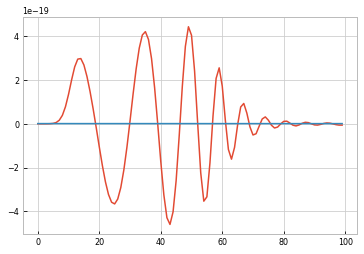

In [520]:
mean, var = generator.time_domain_waveform({'mass ratio': .8})
plt.plot(mean.cpu())
plt.plot(var.cpu())
#plt.plot(np.sqrt(generator.time_domain_waveform({'mass ratio': 0.11})[1].cpu()))

In [521]:
list(model.parameters())

[Parameter containing:
 tensor([16.3154], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-16.3161]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-16.3159]], device='cuda:0', requires_grad=True)]

In [497]:
list(model.parameters())

[Parameter containing:
 tensor([3.3169], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-5.6782]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([[-5.8714]], device='cuda:0', requires_grad=True)]

In [522]:
def cuda_conj(tensor):
    new_tensor = tensor.clone()
    new_tensor[:,1] = tensor[:,1] * -1
    return new_tensor

def cuda_product(a, b):
    return torch.stack([a[:,0]*b[:,0] + a[:,1]*b[:,1], a[:,0]*b[:,1] + a[:,1]*b[:,0]], dim=1)

In [523]:
waveform = generator.frequency_domain_waveform({'mass ratio': 1})

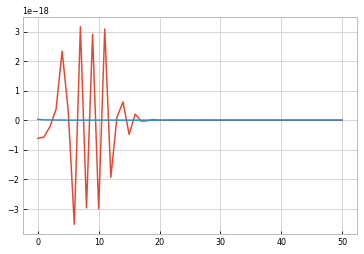

In [524]:
plt.plot(generator.frequency_domain_waveform({'mass ratio': 1.0})[0][:,0].cpu())
plt.plot(generator.frequency_domain_waveform({'mass ratio': 1.0})[1][:,0].cpu())

In [526]:
l._inner_product({'mass ratio': 0.99}),  l._inner_product({'mass ratio': 0.95})

(tensor(-1.8580e+12, device='cuda:0', dtype=torch.float64),
 tensor(8.6364e+08, device='cuda:0', dtype=torch.float64))

In [527]:
l({'mass ratio': 0.95})

tensor(4.3182e+08, device='cuda:0', dtype=torch.float64)

In [529]:
l({'mass ratio': 0.99})

tensor(-9.2898e+11, device='cuda:0', dtype=torch.float64)

In [ ]:
integrand = cuda_conj(aa[0]) * bb[0]
#return 4 / duration * np.sum(integrand)

In [ ]:
duration = 0.1

inner_product = 4 / duration * torch.sum(integrand)

In [ ]:
inner_product.cpu().numpy()

In [ ]:
size = 1000

times = np.linspace(-2, 2, 1000)
q = 0.4

points = np.ones((1000,2))
points[:,0] = times
points[:,1] = points[:,1] * q * 100

test_x = torch.tensor(points).float()
test_x = test_x.cuda()

In [ ]:
#%%timeit
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    f_preds = model(test_x)
    y_preds = likelihood(f_preds)

In [ ]:
with torch.no_grad():
    lower, upper = y_preds.confidence_region()
    f, ax = plt.subplots(1,1, dpi=300)
    ax.plot(test_x[:,0].cpu().numpy(), f_preds.mean.cpu().numpy()/1e21)
    #samples = y_preds.sample_n(100)
    #for sample in samples:
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,0], alpha=0.01, color='r')
    #    ax.plot(test_x[:,0].numpy(), sample.numpy()[:,1], alpha=0.01, color='b')
    #ax.plot(training_x[:,0].cpu(), training_y.cpu()/1e21, '+')
    ax.fill_between(test_x[:,0].cpu().numpy(), lower.cpu().numpy()/1e21, upper.cpu().numpy()/1e21, alpha=0.5)